## Iterative Solutions to Inverse Problems
This somewhat brief notebook will illustrate a simple approach to incorporating regularization in an inverse problem solver via projected gradient descent.

Remember that we were interested in finding $f$ that minimized expressions that looked like:
$$f^* = \min_f || \, y - A \, f \, ||_2^2 + \lambda \ r(f) $$,
where $r(f)$ is some regularizer. For Tikhonov-style $r(f)$, where $r(f) = ||f||^2$ is some squared norm, this is straightforward to compute. However, for more general regularizers solving these optimization problems can be hard.

The following is not the only way to solve problems of this form: it is often suboptimal in terms of solution and slower than necessary, but this is a fairly flexible method.

We'll be running a form of proximal gradient descent, which consists of taking gradient steps followed by denoising steps. A simple function to do that is here:

In [50]:
def simple_alternating_optimizer(initial_point, gradient_step, denoiser, n_steps, delta_tolerance):
    f_t = initial_point
    for ii in range(n_steps):
        f_tminus1 = f_t
        z_t = gradient_step(f_t)
        f_t = denoiser(z_t)

        delta = np.mean(np.square(f_t - f_tminus1)[:])
        if delta < delta_tolerance:
            break
        if ii % 50 == 0:
            print('Delta: ' + str(delta))

    return f_t

Before we get to the rest, let's load our data in:

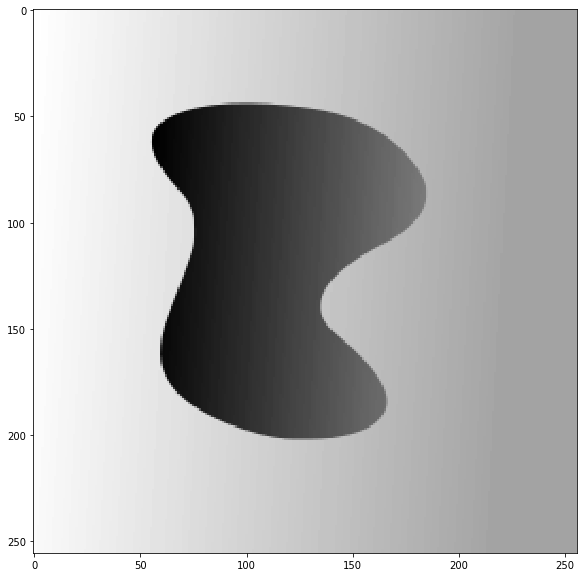

In [51]:
import imageio, os, utils
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]

cwd = os.getcwd()
image_folder = cwd + "/images/"

example_image_path = image_folder + "blob.png"
test_image = imageio.imread(example_image_path, pilmode='L')

fig = plt.figure()
plt.imshow(test_image, cmap='gray')
plt.show()

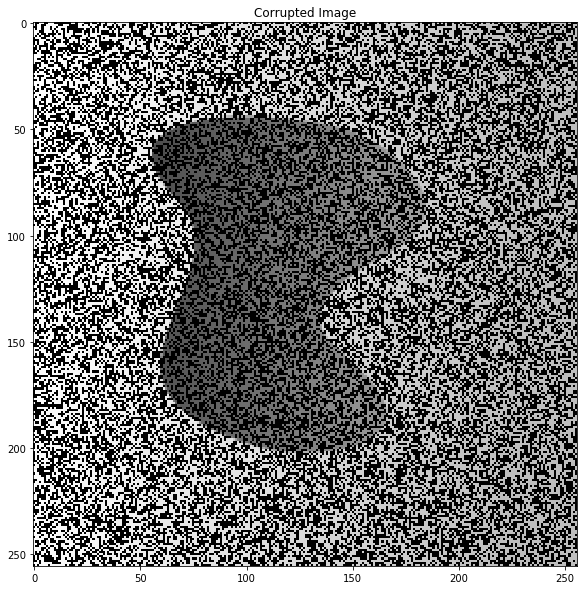

In [52]:
import corruption_models
pixel_deletion_mask = corruption_models.get_inpainting_map(np.shape(test_image), p=0.5)
corrupted_image = corruption_models.apply_inpainting_map(test_image, pixel_deletion_mask)

fig = plt.figure()
plt.imshow(corrupted_image, cmap='gray'); plt.title("Corrupted Image")
plt.show()

We'll define a gradient step below - there are a number of ways to make this gradient step behave better, but we'll stick with a simple one.

In [55]:
from skimage import restoration
def inpaint_gradient_step(input_data, inpaint_mask, initial_point, stepsize):
    gradient_inner_term = initial_point - corruption_models.apply_inpainting_map(input_data, inpaint_mask)
    gradient_step = corruption_models.apply_inpainting_map(gradient_inner_term, inpaint_mask)
    return input_data + stepsize*gradient_step

tv_maxiters = 50
tv_lambda = 10
is_multichannel = False
denoiser = lambda x: restoration.denoise_tv_chambolle(x, weight=tv_lambda, n_iter_max=tv_maxiters, multichannel=is_multichannel)

stepsize = 0.1
initial_point = corrupted_image
gradient_step = lambda x: inpaint_gradient_step(x, pixel_deletion_mask, initial_point, stepsize)

n_steps = 100
delta_tolerance = 1e-7

reconstruction = simple_alternating_optimizer(initial_point, gradient_step, denoiser, n_steps, delta_tolerance)


Delta: 330.7389159937654
Delta: 0.2023055981364778


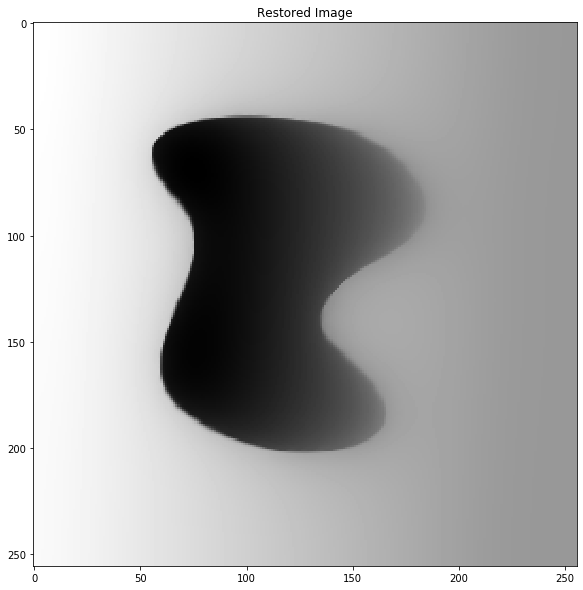

In [56]:
fig = plt.figure()
plt.imshow(reconstruction, cmap='gray'); plt.title("Restored Image")
plt.show()

Try out what happens when you change the input image to the cameraman! Code below can be used to import the cameraman - you may have to tweak some parameters but it shouldn't take too many changes. Notably, the blob image is much smoother, so having a high TV regularization term is okay in that case.

Delta: 3.5334993159100367
Delta: 0.8194059993673761
Delta: 0.23623364739664426
Delta: 0.02094684839250339
Delta: 0.0015341427325853143
Delta: 0.0004152083471308965
Delta: 0.0001745665665129555
Delta: 9.310219080365432e-05
Delta: 5.634631144502869e-05
Delta: 2.934979814283404e-05


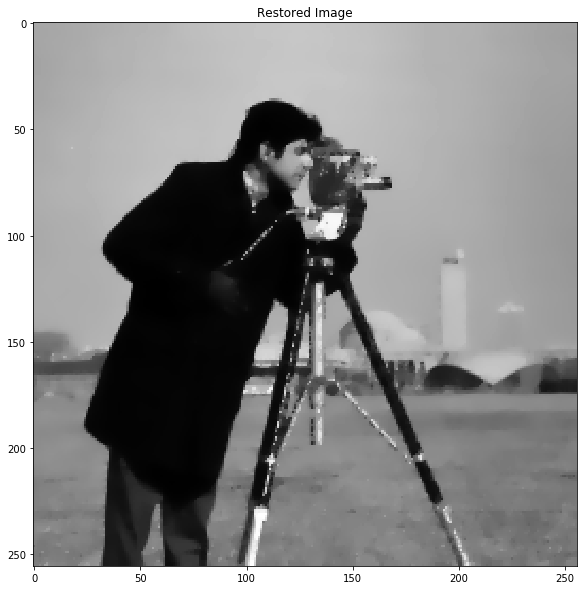

In [49]:
example_image_path = image_folder + "cameraman.jpg"
test_image = imageio.imread(example_image_path)
pixel_deletion_mask = corruption_models.get_inpainting_map(np.shape(test_image), p=0.5)
corrupted_image = corruption_models.apply_inpainting_map(test_image, pixel_deletion_mask)

tv_maxiters = 50
tv_lambda = 1
is_multichannel = False
denoiser = lambda x: restoration.denoise_tv_chambolle(x, weight=tv_lambda, n_iter_max=tv_maxiters, multichannel=is_multichannel)

stepsize = 0.1
initial_point = corrupted_image
gradient_step = lambda x: inpaint_gradient_step(x, pixel_deletion_mask, initial_point, stepsize)

n_steps = 500
delta_tolerance = 1e-7

reconstruction = simple_alternating_optimizer(initial_point, gradient_step, denoiser, n_steps, delta_tolerance)

fig = plt.figure()
plt.imshow(reconstruction, cmap='gray'); plt.title("Restored Image")
plt.show()